In [ ]:
import undetected_chromedriver as uc
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import csv
import time

def scrape_csgoskins_table(main_html):
    """
    csgoskins.txt içindeki HTML tablodan
    (skin_adı, rarity, collection, link) verilerini
    liste olarak döndürüyor.
    """
    soup = BeautifulSoup(main_html, 'html.parser')
    table = soup.find('table')
    if not table:
        return []
    tbody = table.find('tbody')
    if not tbody:
        return []
    
    rows = tbody.find_all('tr')
    data = []
    for row in rows:
        cols = row.find_all('td')
        if len(cols) < 4:
            continue
        
        # 1. kolon -> skin adı & link
        skin_link_tag = cols[0].find('a')
        if not skin_link_tag:
            continue
        skin_name = skin_link_tag.text.strip()
        skin_link = skin_link_tag.get('href', '').strip()

        rarity = cols[1].text.strip()
        collection = cols[2].text.strip()
        
        data.append((skin_name, rarity, collection, skin_link))
    return data


def scrape_skin_prices_selenium(driver, skin_url):
    """
    Selenium ile belirtilen `skin_url` sayfasını açar,
    tablo-overflow class'lı tabloda "Steam" satırındaki fiyatları döndürür.
    [(kalite, fiyat), (kalite, fiyat), ...] formatında bir liste döner.
    """
    results = []
    try:
        driver.get(skin_url)
        # Bekleme süresini artırdık (10 sn)
        time.sleep(3)

        page_source = driver.page_source
        soup = BeautifulSoup(page_source, 'html.parser')

        price_table_div = soup.find('div', class_='table-overflow')
        if not price_table_div:
            print("  [DEBUG] 'table-overflow' class'lı div bulunamadı!")
            # Sayfada gerçekten ne var görelim (ilk 2000 karakter)
            print("  [DEBUG] Sayfanın ilk 2000 karakteri:\n", soup.prettify()[:2000])
            return results
        
        price_table = price_table_div.find('table')
        if not price_table:
            print("  [DEBUG] 'table-overflow' div var ama içinde <table> yok!")
            # Biraz HTML göster
            print("  [DEBUG] table-overflow div içeriği:\n", price_table_div.prettify()[:2000])
            return results
        
        thead = price_table.find('thead')
        tbody = price_table.find('tbody')
        if not thead or not tbody:
            print("  [DEBUG] Tablonun <thead> veya <tbody> kısmı yok!")
            return results
        
        th_list = thead.find_all('th')
        if len(th_list) <= 1:
            print("  [DEBUG] <th> sayısı beklenenden az!")
            return results

        quality_headers = [th.text.strip() for th in th_list[1:]]
        rows = tbody.find_all('tr')
        if not rows:
            print("  [DEBUG] <tbody> içinde <tr> yok, fiyat satırı bulunamadı!")
            return results
        
        # Steam satırı (ilk satır) varsayımı
        steam_row = rows[0]
        tds = steam_row.find_all('td')
        price_tds = tds[1:]
        
        for q_header, price_td in zip(quality_headers, price_tds):
            price_text = price_td.get_text(strip=True)
            if price_text.lower() == "no listings":
                continue
            
            price_clean = price_text.replace('$', '').strip()
            results.append((q_header, price_clean))
        
    except Exception as e:
        print(f"scrape_skin_prices_selenium hata: {e}")

    return results


def main():
    # 1) csgoskins.txt dosyasını oku
    with open("csgoskins.txt", "r", encoding="utf-8") as f:
        main_html = f.read()

    # 2) csgoskins.txt içerisindeki ana tabloyu parse et
    skins_data = scrape_csgoskins_table(main_html)

    # 3) Selenium (undetected_chromedriver) başlat
    chrome_options = Options()
    # BAŞLIĞI KAPATIYORUZ Kİ GÖZLE GÖREBİLELİM
    #chrome_options.add_argument("--headless")  
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-gpu")

    driver = uc.Chrome(options=chrome_options)
    
    with open("csgoskins_output.csv", "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["skin_adı", "nadirliği", "koleksiyonu", "kalitesi", "fiyatı"])

        for (skin_name, rarity, collection, link) in skins_data:
            # Link tam değilse ekleme gerekebilir:
            # if not link.startswith("http"):
            #     link = "https://www.csgodatabase.com" + link

            print(f"Skin işleniyor: {skin_name} => {link}")
            price_list = scrape_skin_prices_selenium(driver, link)

            if not price_list:
                print(f"  [UYARI] '{skin_name}' için fiyat bilgisi bulunamadı.")
            else:
                for (quality, price) in price_list:
                    writer.writerow([skin_name, rarity, collection, quality, price])
                    print(f"  Yazıldı: {skin_name}, {rarity}, {collection}, {quality}, {price}")

    driver.quit()
    print("İşlem tamamlandı. 'csgoskins_output.csv' dosyası oluşturuldu.")


if __name__ == "__main__":
    main()


In [41]:
import pandas as pd

# Load the uploaded CSV file to inspect its contents
file_path = 'csgoskins_output.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()

# Remove duplicate entries
data_cleaned = data.drop_duplicates()

# Check for missing or invalid values
missing_values = data_cleaned.isnull().sum()

# Convert the 'fiyatı' column to numeric (it might contain strings or commas)
data_cleaned['fiyatı'] = pd.to_numeric(data_cleaned['fiyatı'], errors='coerce')

# Drop rows where 'fiyatı' is NaN after conversion
data_cleaned = data_cleaned.dropna(subset=['fiyatı'])

# Display cleaned data summary and missing values
data_cleaned.info(), missing_values

# Define a list of known weapon names to split the data correctly
weapons = [
    "AWP", "Desert Eagle", "AK-47", "M4A4", "M4A1-S", "Glock-18", "P2000", "USP-S", 
    "P250", "CZ75-Auto", "R8 Revolver", "FAMAS", "Galil AR", "AUG", "SG 553", 
    "SCAR-20", "G3SG1", "MAC-10", "MP9", "MP7", "MP5-SD", "UMP-45", "PP-Bizon", 
    "P90", "Nova", "XM1014", "MAG-7", "Sawed-Off", "Negev", "M249", "Tec-9", "Five-SeveN"
]

# Split the "skin_adı" column into two based on weapon names
def split_skin(row):
    for weapon in weapons:
        if row.startswith(weapon):
            return weapon, row[len(weapon):].strip()
    return None, row

data_cleaned[['silah_ismi', 'skin_ismi']] = data_cleaned['skin_adı'].apply(lambda x: pd.Series(split_skin(x)))

# Drop the old "skin_adı" column
data_cleaned = data_cleaned.drop(columns=['skin_adı'])

data_cleaned = data_cleaned[['silah_ismi', 'skin_ismi', 'nadirliği', 'koleksiyonu', 'kalitesi', 'fiyatı']]

data_cleaned.head()


<class 'pandas.core.frame.DataFrame'>
Index: 9744 entries, 0 to 9789
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   skin_adı     9744 non-null   object 
 1   nadirliği    9744 non-null   object 
 2   koleksiyonu  9744 non-null   object 
 3   kalitesi     9744 non-null   object 
 4   fiyatı       9744 non-null   float64
dtypes: float64(1), object(4)
memory usage: 456.8+ KB


,silah_ismi,skin_ismi,nadirliği,koleksiyonu,kalitesi,fiyatı
0,AWP,Lightning Strike,Covert,The Arms Deal Collection,Factory New,727.52
1,AWP,Lightning Strike,Covert,The Arms Deal Collection,Minimal Wear,717.11
3,Desert Eagle,Hypnotic,Classified,The Arms Deal Collection,Factory New,112.19
4,Desert Eagle,Hypnotic,Classified,The Arms Deal Collection,Minimal Wear,113.42
5,Desert Eagle,Hypnotic,Classified,The Arms Deal Collection,StatTrak™Factory New,174.89


In [42]:
data_cleaned.to_csv('clean_skin_data.csv', index=False)

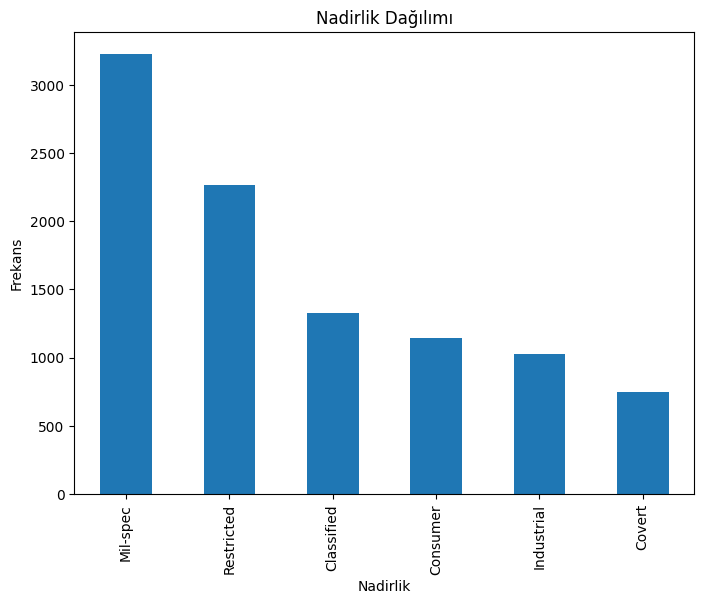

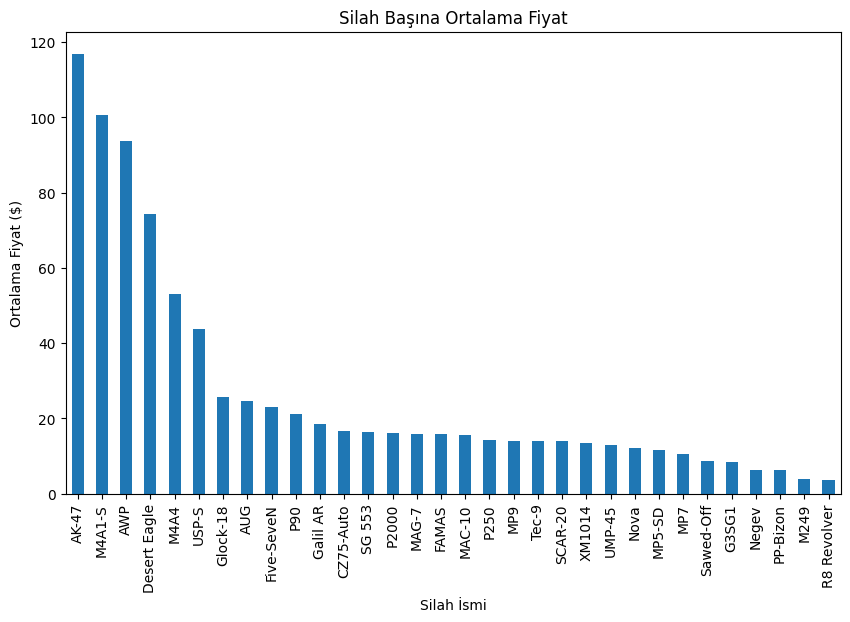

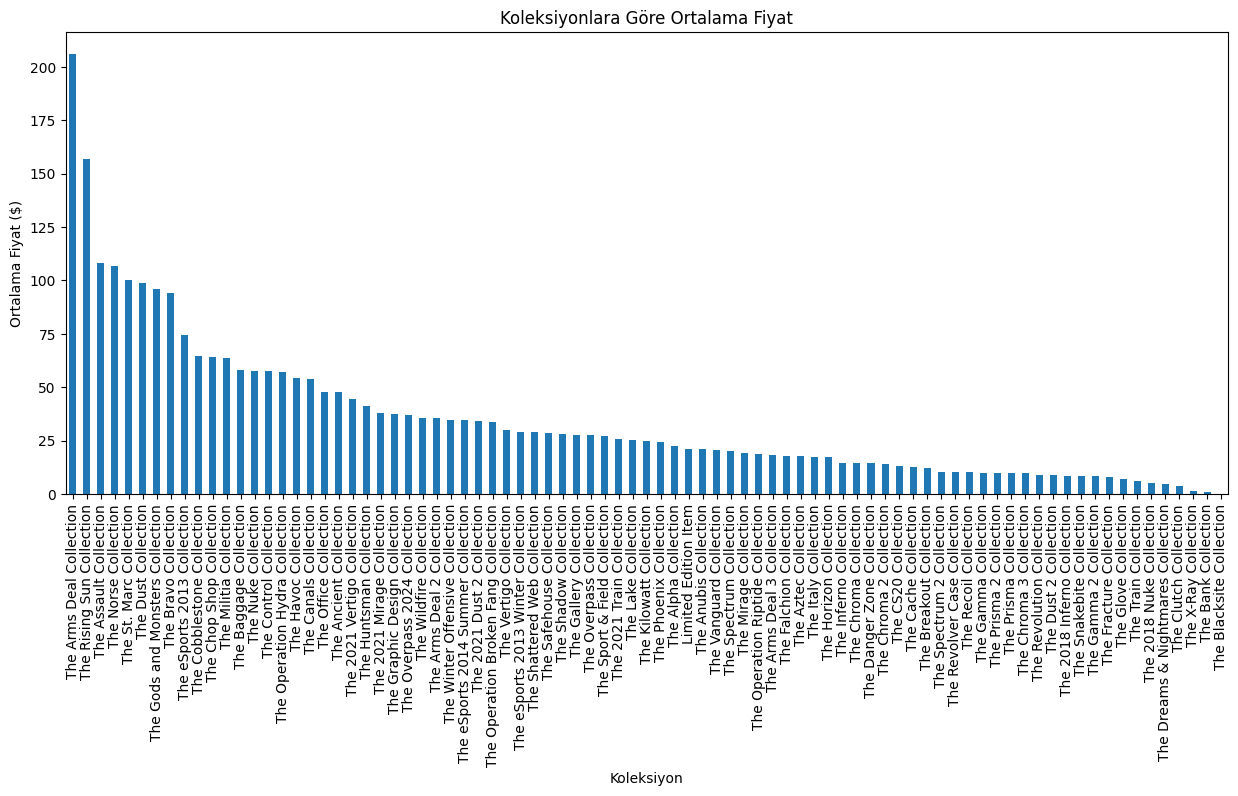

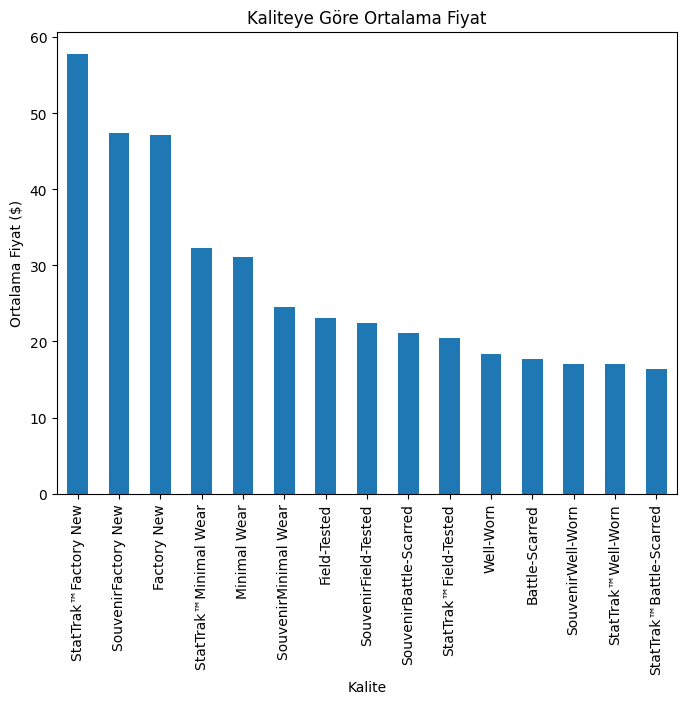

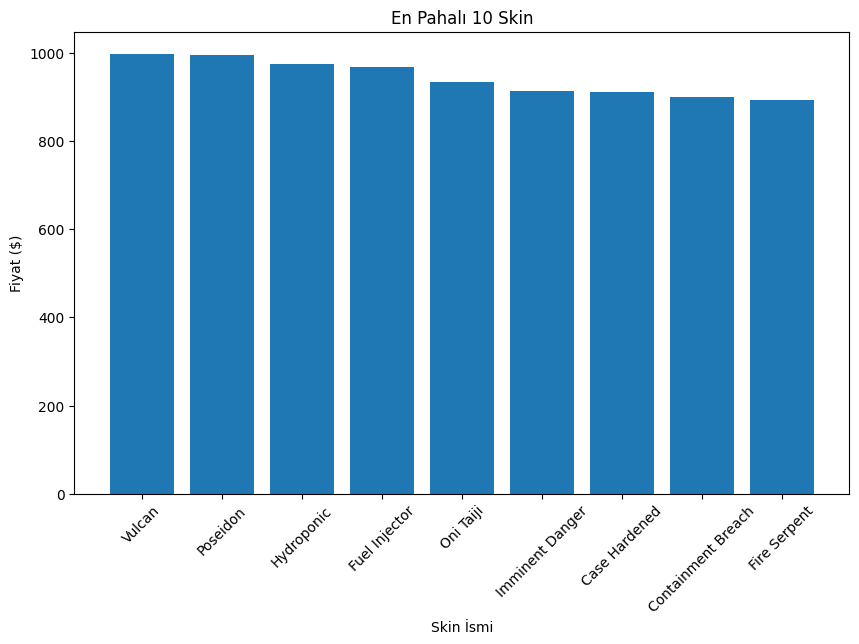

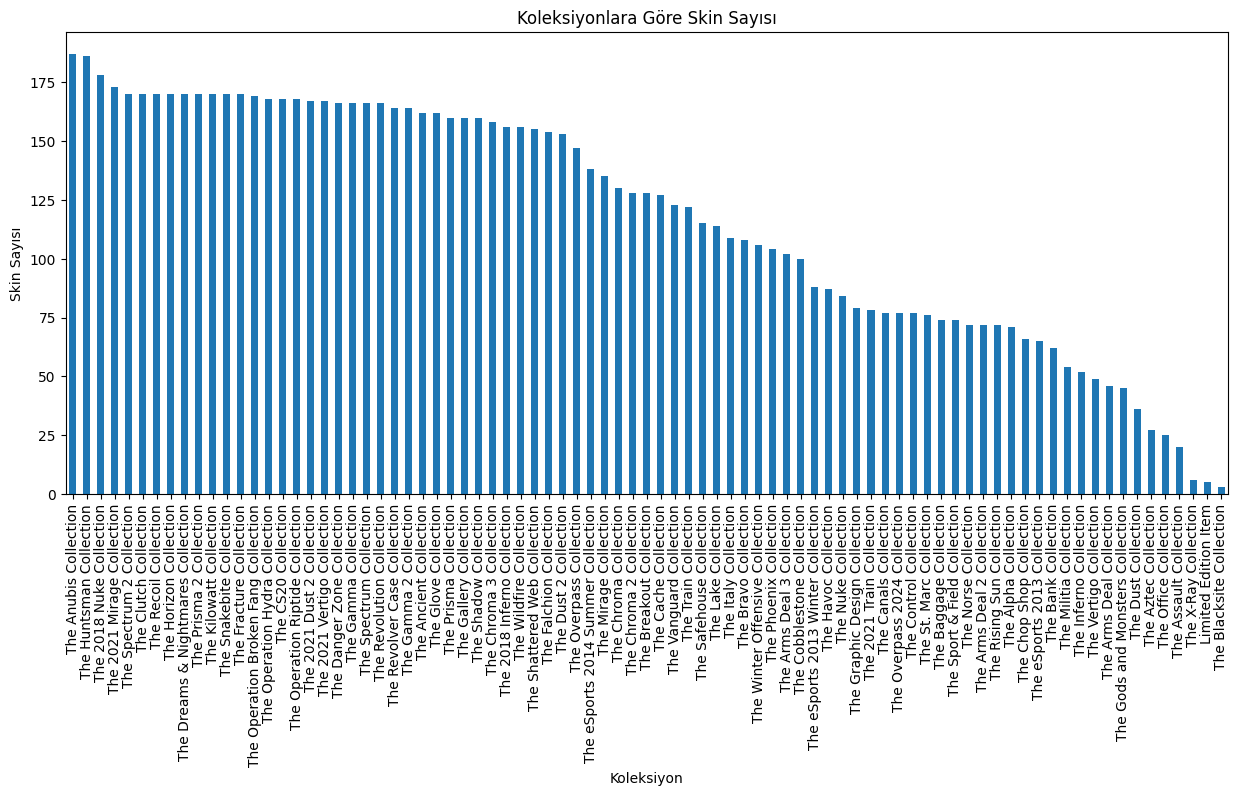

In [48]:
import matplotlib.pyplot as plt

data = pd.read_csv('clean_skin_data.csv')


# 1. Nadirlik Dağılımı
rarity_distribution = data['nadirliği'].value_counts()
plt.figure(figsize=(8,6))
rarity_distribution.plot(kind='bar', title='Nadirlik Dağılımı')
plt.xlabel('Nadirlik')
plt.ylabel('Frekans')
plt.show()

# 2. Silah Başına Ortalama Fiyat
weapon_avg_price = data.groupby('silah_ismi')['fiyatı'].mean().sort_values(ascending=False)
plt.figure(figsize=(10,6))
weapon_avg_price.plot(kind='bar', title='Silah Başına Ortalama Fiyat')
plt.xlabel('Silah İsmi')
plt.ylabel('Ortalama Fiyat ($)')
plt.show()

# 3. Koleksiyonlara Göre Ortalama Fiyat
collection_avg_price = data.groupby('koleksiyonu')['fiyatı'].mean().sort_values(ascending=False)
plt.figure(figsize=(15,6))
collection_avg_price.plot(kind='bar', title='Koleksiyonlara Göre Ortalama Fiyat')
plt.xlabel('Koleksiyon')
plt.ylabel('Ortalama Fiyat ($)')
plt.show()

# 4. Kaliteye Göre Fiyat Dağılımı
quality_avg_price = data.groupby('kalitesi')['fiyatı'].mean().sort_values(ascending=False)
plt.figure(figsize=(8,6))
quality_avg_price.plot(kind='bar', title='Kaliteye Göre Ortalama Fiyat')
plt.xlabel('Kalite')
plt.ylabel('Ortalama Fiyat ($)')
plt.show()

# 5. Tüm Koleksiyonlarda En Pahalı Skin
expensive_skins = data.sort_values(by='fiyatı', ascending=False).head(10)
plt.figure(figsize=(10,6))
plt.bar(expensive_skins['skin_ismi'], expensive_skins['fiyatı'])
plt.title('En Pahalı 10 Skin')
plt.xlabel('Skin İsmi')
plt.ylabel('Fiyat ($)')
plt.xticks(rotation=45)
plt.show()

# 6. Koleksiyonlara Göre Skin Sayısı
collection_skin_count = data['koleksiyonu'].value_counts()
plt.figure(figsize=(15,6))
collection_skin_count.plot(kind='bar', title='Koleksiyonlara Göre Skin Sayısı')
plt.xlabel('Koleksiyon')
plt.ylabel('Skin Sayısı')
plt.show()
